In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/Hugging Face


In [ ]:
import os

# Change this path to your target folder in Drive
dataset_dir = '/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple'

os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset tarball (replace with actual URL)
!wget -O minneapple.tar.gz https://conservancy.umn.edu/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/download

# Extract
!tar -tf minneapple.tar.gz | head -3

# ✅ Extract directly into the datasets folder (not nested again)
!tar -xzf minneapple.tar.gz -C "$dataset_dir"

print("MinneApple dataset downloaded and extracted to", dataset_dir)

--2025-07-08 10:56:01--  https://conservancy.umn.edu/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/download
Resolving conservancy.umn.edu (conservancy.umn.edu)... 134.84.72.217
Connecting to conservancy.umn.edu (conservancy.umn.edu)|134.84.72.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://conservancy.umn.edu/server/api/core/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/content [following]
--2025-07-08 10:56:02--  https://conservancy.umn.edu/server/api/core/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/content
Reusing existing connection to conservancy.umn.edu:443.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/gzip]
Saving to: ‘minneapple.tar.gz’

minneapple.tar.gz       [              <=>   ]   1.70G  30.3MB/s    in 60s     

2025-07-08 10:57:02 (29.0 MB/s) - ‘minneapple.tar.gz’ saved [1825397590]

detection/test/images/dataset2_back_630.png
detection/train/masks/20150919_174151_image11.png
detection/t

In [2]:
!mkdir -p "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple"
!ls "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple"

best_retinanet_model.pth  detection


In [4]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/MinneApple/detection/train_split/images")
count_images("datasets/MinneApple/detection/train_split/masks")
count_images("datasets/MinneApple/detection/test/images")

Total images: 536
Total images: 536
Total images: 331


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# === CONFIG ===
ROOT_DIR = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection"
IMAGE_DIR = os.path.join(ROOT_DIR, "train/images")
MASK_DIR = os.path.join(ROOT_DIR, "train/masks")
SPLIT_DIR = ROOT_DIR  # train_split/ and val_split/ will go here

SPLIT_RATIO = 0.8
SEED = 42

# === Step 1: Collect image filenames ===
all_images = [f for f in os.listdir(IMAGE_DIR) if f.endswith((".png", ".jpg", ".jpeg"))]
all_images.sort()
random.seed(SEED)
random.shuffle(all_images)

split_idx = int(len(all_images) * SPLIT_RATIO)
train_files = all_images[:split_idx]
val_files = all_images[split_idx:]

print(f"Train: {len(train_files)} images, Val: {len(val_files)} images")

# === Step 2: Prepare folders ===
for split in ["train_split", "val_split"]:
    os.makedirs(os.path.join(SPLIT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(SPLIT_DIR, split, "masks"), exist_ok=True)

# === Step 3: Move images and masks ===
def move_image_and_masks(file_list, split_name):
    for img_file in tqdm(file_list, desc=f"Moving {split_name}"):
        base = os.path.splitext(img_file)[0]
        img_path = os.path.join(IMAGE_DIR, img_file)
        mask_path = os.path.join(MASK_DIR, base + ".png")

        shutil.move(img_path, os.path.join(SPLIT_DIR, split_name, "images", img_file))
        shutil.move(mask_path, os.path.join(SPLIT_DIR, split_name, "masks", base + ".png"))

move_image_and_masks(train_files, "train_split")
move_image_and_masks(val_files, "val_split")

Train: 0 images, Val: 0 images


Moving train_split: 0it [00:00, ?it/s]
Moving val_split: 0it [00:00, ?it/s]


In [ ]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm

SPLIT_DIR = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection"
CATEGORY_NAME = "apple"

def masks_to_coco_from_grayscale_instances(split_name, save_path):
    image_folder = os.path.join(SPLIT_DIR, split_name, "images")
    mask_folder = os.path.join(SPLIT_DIR, split_name, "masks")

    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": CATEGORY_NAME}]
    }

    ann_id = 1
    image_files = sorted(os.listdir(image_folder))
    for img_id, img_file in enumerate(tqdm(image_files, desc=f"COCO for {split_name}")):
        img_path = os.path.join(image_folder, img_file)
        height, width = cv2.imread(img_path).shape[:2]

        coco["images"].append({
            "id": img_id,
            "file_name": img_file,
            "width": width,
            "height": height
        })

        base = os.path.splitext(img_file)[0]
        mask_path = os.path.join(mask_folder, base + ".png")
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # preserve original values

        if mask is None or mask.max() == 0:
            continue

        instance_ids = np.unique(mask)
        instance_ids = instance_ids[instance_ids != 0]  # ignore background

        for inst_id in instance_ids:
            binary_mask = (mask == inst_id).astype(np.uint8)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                continue

            for cnt in contours:
                area = float(cv2.contourArea(cnt))
                if area < 10:  # skip very small objects if desired
                    continue

                x, y, w, h = cv2.boundingRect(cnt)
                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": 1,
                    "bbox": [x, y, w, h],
                    "area": area,
                    "iscrowd": 0
                })
                ann_id += 1

    with open(save_path, "w") as f:
        json.dump(coco, f, indent=2)

# Run for train and val splits
masks_to_coco_from_grayscale_instances("train_split", os.path.join(SPLIT_DIR, "instances_train.json"))
masks_to_coco_from_grayscale_instances("val_split", os.path.join(SPLIT_DIR, "instances_val.json"))

COCO for val_split: 100%|██████████| 134/134 [00:10<00:00, 12.33it/s]


In [ ]:
# Check train annotations
with open("datasets/MinneApple/detection/instances_train.json") as f:
    train_data = json.load(f)
    print(f"Train images: {len(train_data['images'])}")
    print(f"Train annotations: {len(train_data['annotations'])}")
    print(f"Categories: {train_data['categories']}")

# Check validation
with open("datasets/MinneApple/detection/instances_val.json") as f:
    valid_data = json.load(f)
    print(f"\nValid images: {len(valid_data['images'])}")
    print(f"Valid annotations: {len(valid_data['annotations'])}")
    print(f"Categories: {valid_data['categories']}")

Train images: 536
Train annotations: 22595
Categories: [{'id': 1, 'name': 'apple'}]

Valid images: 134
Valid annotations: 5582
Categories: [{'id': 1, 'name': 'apple'}]


Image: 20150921_132038_image1196.png
  BBoxes count from JSON: 8
  Unique instances in mask: 8
Image: 20150919_174151_image381.png
  BBoxes count from JSON: 85
  Unique instances in mask: 85
Image: 20150921_131453_image1056.png
  BBoxes count from JSON: 56
  Unique instances in mask: 56
Image: 20150921_131453_image626.png
  BBoxes count from JSON: 16
  Unique instances in mask: 16


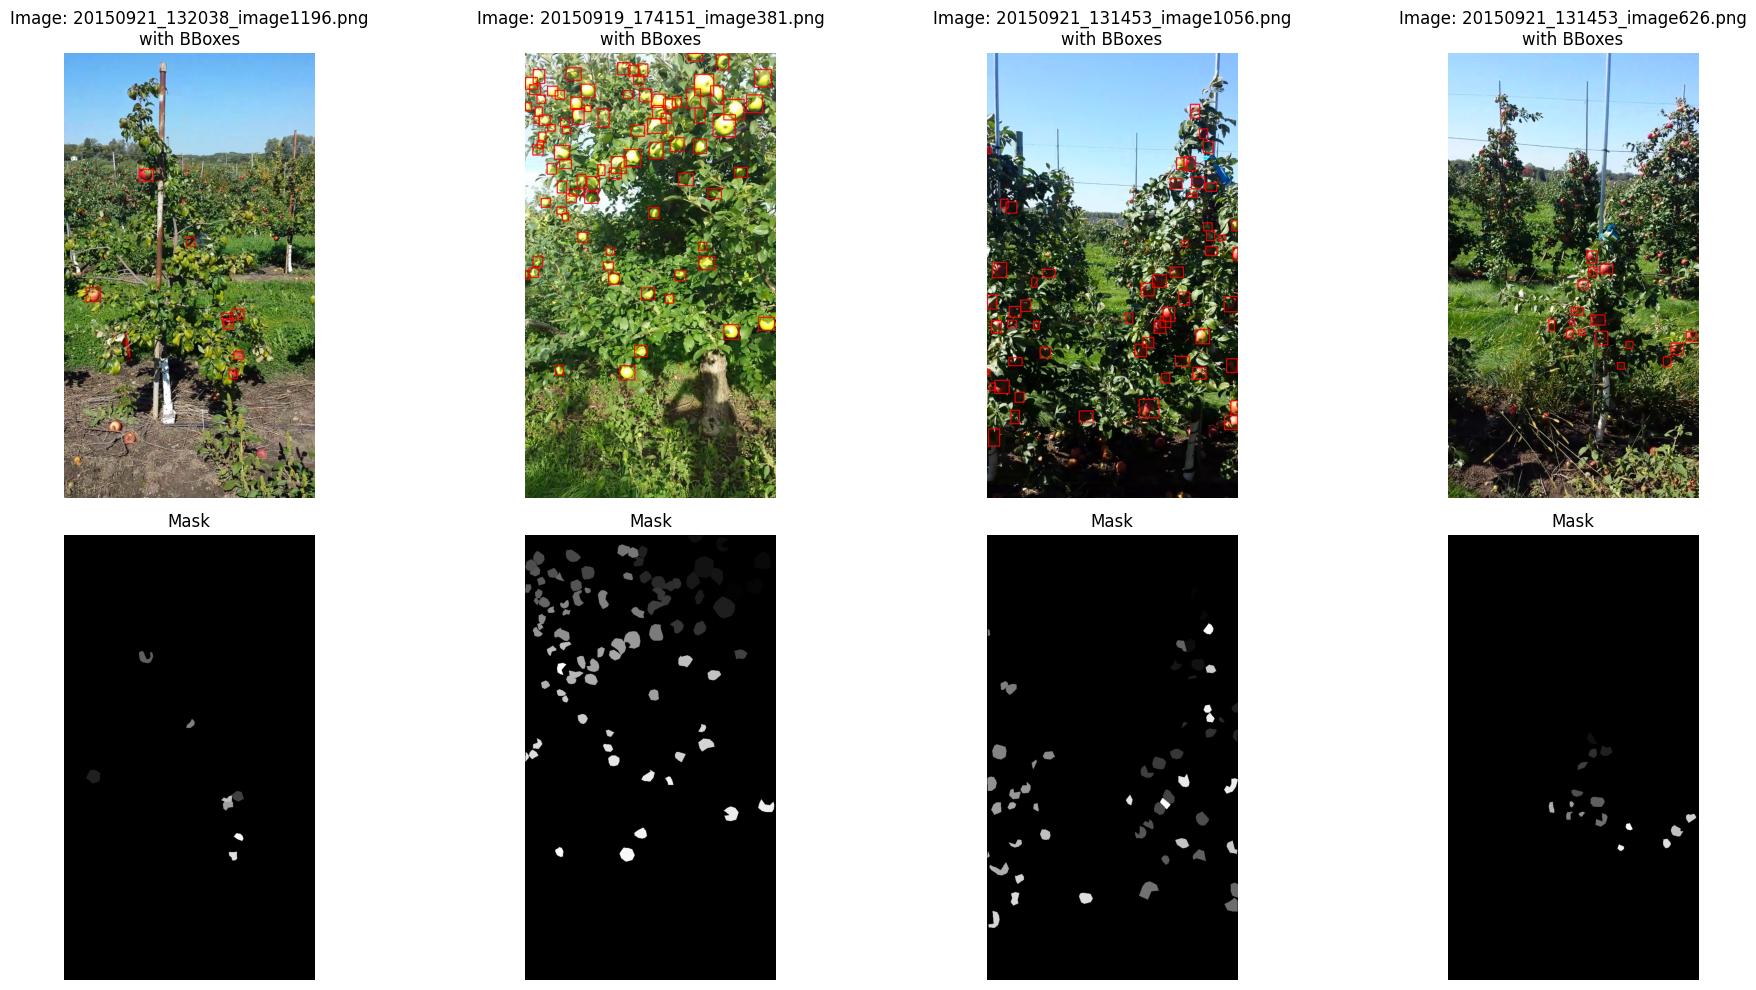

In [ ]:
import os
import random
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

ROOT_DIR = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection"
TRAIN_SPLIT = os.path.join(ROOT_DIR, "train_split")
IMAGE_DIR = os.path.join(TRAIN_SPLIT, "images")
MASK_DIR = os.path.join(TRAIN_SPLIT, "masks")
JSON_PATH = os.path.join(ROOT_DIR, "instances_train.json")

# Load COCO annotations
with open(JSON_PATH) as f:
    coco = json.load(f)

# Build dict: image_id -> list of bboxes
image_id_to_bboxes = {}
for ann in coco['annotations']:
    image_id_to_bboxes.setdefault(ann['image_id'], []).append(ann['bbox'])

# Build dict: image_id -> file_name
image_id_to_name = {img['id']: img['file_name'] for img in coco['images']}

# Randomly select 4 image_ids
random.seed(40)
sample_image_ids = random.sample(list(image_id_to_name.keys()), 4)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, img_id in enumerate(sample_image_ids):
    img_name = image_id_to_name[img_id]
    img_path = os.path.join(IMAGE_DIR, img_name)
    mask_path = os.path.join(MASK_DIR, os.path.splitext(img_name)[0] + ".png")

    # Load image and mask
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Count bboxes in JSON for this image
    bbox_count = len(image_id_to_bboxes.get(img_id, []))
    # Count unique apple instances in mask (exclude background=0)
    unique_instances = len(np.unique(mask)) - (1 if 0 in np.unique(mask) else 0)

    print(f"Image: {img_name}")
    print(f"  BBoxes count from JSON: {bbox_count}")
    print(f"  Unique instances in mask: {unique_instances}")

    # Draw bboxes on image copy
    img_with_boxes = img.copy()
    for bbox in image_id_to_bboxes.get(img_id, []):
        x, y, w, h = map(int, bbox)
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Plot original image with bboxes
    axs[0, i].imshow(img_with_boxes)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Image: {img_name}\nwith BBoxes")

    # Plot original mask
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Mask")

plt.tight_layout()
plt.show()

In [ ]:
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.cuda.amp.autocast.*")

In [4]:
from detectron2.data.datasets import register_coco_instances
import os

data_dir = "datasets/MinneApple/detection"

register_coco_instances("Apple_train", {},
                        os.path.join(data_dir, "instances_train.json"),
                        os.path.join(data_dir, "train_split/images"))

register_coco_instances("Apple_val", {},
                        os.path.join(data_dir, "instances_val.json"),
                        os.path.join(data_dir, "val_split/images"))

In [5]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")

# Dataset
cfg.DATASETS.TRAIN = ("Apple_train",)
cfg.DATASETS.TEST = ("Apple_val",)
cfg.INPUT.MIN_SIZE_TRAIN = (1024, 1152, 1280)
cfg.INPUT.MAX_SIZE_TRAIN = 2048

cfg.INPUT.MIN_SIZE_TEST = 1280
cfg.INPUT.MAX_SIZE_TEST = 2048
cfg.DATALOADER.NUM_WORKERS = 8

# Training setup
cfg.SOLVER.IMS_PER_BATCH = 12
num_images = 536
epochs = 40
iters_per_epoch = num_images // cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
# Dynamic LR step schedule (50% and 80% of total iters)
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.STEPS = (
    int(cfg.SOLVER.MAX_ITER * 0.5),
    int(cfg.SOLVER.MAX_ITER * 0.8)
)
# Evaluate every 5 epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * 2 # 5 epoch
cfg.SOLVER.GAMMA = 0.1
warmup_iters = min(200, int(iters_per_epoch * 2))
cfg.SOLVER.WARMUP_ITERS = warmup_iters

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]  # add smaller sizes
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0]]

cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.SOLVER.AMP.ENABLED = True  # Enable automatic mixed precision for speedup

cfg.SOLVER.CHECKPOINT_PERIOD = 200
cfg.OUTPUT_DIR = "/content/.cache/detectron2_RetinaNet_Apple"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
from detectron2.engine import hooks
from detectron2.evaluation import inference_on_dataset
import torch
import math

class BestModelSaver(hooks.EvalHook):
    def __init__(self, eval_period, model, evaluator, val_loader, save_path):
        super().__init__(eval_period, self.eval_function)
        self.model = model
        self.evaluator = evaluator
        self.val_loader = val_loader
        self.save_path = save_path
        self.best_ap = -1.0

    def eval_function(self):
        results = inference_on_dataset(self.model, self.val_loader, self.evaluator)
        bbox_results = results.get("bbox") if results else None

        if bbox_results and "AP" in bbox_results:
            curr_ap = bbox_results["AP"]
            if curr_ap is not None and not math.isnan(curr_ap):
                print(f"📈 Eval AP: {curr_ap:.4f} | Best so far: {self.best_ap:.4f}")
                if curr_ap > self.best_ap:
                    print(f"🥇 New best model! Saving to {self.save_path}")
                    torch.save(self.model.state_dict(), self.save_path)
                    self.best_ap = curr_ap
            else:
                print(f"⚠️ AP is NaN or invalid (value: {curr_ap}), skipping save.")
        else:
            print("⚠️ No valid bbox/AP results found in evaluation output.")

        return results

In [7]:
# Patch COCOEvaluator to avoid missing fields crash:
from pycocotools.coco import COCO
import copy
import json
import time

def patched_loadRes(self, resFile):
    tic = time.time()
    self.dataset.setdefault("info", {})
    self.dataset.setdefault("licenses", [])
    if isinstance(resFile, str):
        with open(resFile, 'r') as f:
            anns = json.load(f)
    elif isinstance(resFile, list):
        anns = resFile
    else:
        raise TypeError('resFile must be a file path or list of dicts')

    res = COCO()
    res.dataset['info'] = copy.deepcopy(self.dataset['info'])
    res.dataset['licenses'] = copy.deepcopy(self.dataset['licenses'])
    res.dataset['images'] = copy.deepcopy(self.dataset['images'])

    assert isinstance(anns, list), 'Annotations must be a list'
    anns_img_ids = [ann['image_id'] for ann in anns]
    assert set(anns_img_ids).issubset(set(self.getImgIds()))

    for idx, ann in enumerate(anns):
        ann.setdefault('id', idx + 1)
        if 'area' not in ann:
            if 'bbox' in ann:
                _, _, w, h = ann['bbox']
                ann['area'] = w * h
            else:
                ann['area'] = 0

    res.dataset['annotations'] = anns
    res.createIndex()
    print(f'Annotations loaded in {time.time() - tic:.2f}s')
    return res

COCO.loadRes = patched_loadRes

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator

trainer = DefaultTrainer(cfg)
val_loader = build_detection_test_loader(cfg, "Apple_val")
evaluator = COCOEvaluator("Apple_val", cfg, False, output_dir=cfg.OUTPUT_DIR)

best_model_path = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_retinanet_model.pth"

trainer.register_hooks([
    BestModelSaver(cfg.TEST.EVAL_PERIOD, trainer.model, evaluator, val_loader, best_model_path)
])

[07/08 17:59:01 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()


In [9]:
torch.cuda.empty_cache()

In [62]:
trainer.resume_or_load(resume=False)
trainer.train()

[07/08 16:26:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl ...


head.bbox_pred.{bias, weight}
head.cls_score.{bias, weight}
  pixel_mean
  pixel_std


[07/08 16:26:10 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[07/08 16:27:02 d2.utils.events]:  eta: 1:14:24  iter: 19  total_loss: 2.699  loss_cls: 1.597  loss_box_reg: 1.102    time: 2.5779  last_time: 2.7446  data_time: 0.0700  last_data_time: 0.0334   lr: 5.4173e-05  max_mem: 21865M
[07/08 16:27:53 d2.utils.events]:  eta: 1:13:58  iter: 39  total_loss: 1.428  loss_cls: 0.7428  loss_box_reg: 0.6628    time: 2.5776  last_time: 2.5891  data_time: 0.0406  last_data_time: 0.0421   lr: 0.00011093  max_mem: 21865M
[07/08 16:28:46 d2.utils.events]:  eta: 1:13:19  iter: 59  total_loss: 1.154  loss_cls: 0.4582  loss_box_reg: 0.697    time: 2.5902  last_time: 2.5856  data_time: 0.0408  last_data_time: 0.0363   lr: 0.0001677  max_mem: 21865M
[07/08 16:29:37 d2.utils.events]:  eta: 1:12:27  iter: 79  total_loss: 0.9751  loss_cls: 0.3603  loss_box_reg: 0.631    time: 2.5903  last_time: 2.6462  data_time: 0.0402  last_data_time: 0.0448   lr: 0.00022446  max_mem: 21865M
[07/08 16:29:58 d2.data.datasets.coco]: Loaded 134 images in COCO format from datasets/M

In [11]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo
import os

# 🔧 Setup config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = "datasets/MinneApple/best_retinanet_model.pth"  # Your best model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.1  # confidence threshold
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.INPUT.MIN_SIZE_TEST = 1280  # ← same as training
cfg.INPUT.MAX_SIZE_TEST = 2048  # ← same as training
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]  # ← same as training
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0]]  # ← same
cfg.SOLVER.AMP.ENABLED = True
cfg.OUTPUT_DIR = "/content/.cache/detectron2_RetinaNet_Apple"

# 🧪 Run evaluation
evaluator = COCOEvaluator("Apple_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "Apple_val")
results = inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)

print("\n📊 Evaluation Results on Saved Best Model:")
print(results)

WARNING [07/08 18:07:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/08 18:07:17 d2.data.datasets.coco]: Loaded 134 images in COCO format from datasets/MinneApple/detection/instances_val.json
[07/08 18:07:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1280, 1280), max_size=2048, sample_style='choice')]
[07/08 18:07:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/08 18:07:17 d2.data.common]: Serializing 134 elements to byte tensors and concatenating them all ...
[07/08 18:07:17 d2.data.common]: Serialized dataset takes 0.20 MiB
[07/08 18:07:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/MinneApple/best_retinanet_model.pth ...
[07/08 18:07:19 d2.evaluation.evaluator]: Start inference on 134 batches
[07/08 18:07:20 d2.e

In [80]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import build_detection_test_loader, DatasetMapper
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import torch
import os

def evaluate_prf1_best(cfg, dataset_name, model_weights, iou_thresh=0.5):
    cfg.MODEL.WEIGHTS = model_weights
    predictor = DefaultPredictor(cfg)

    output_dir = cfg.OUTPUT_DIR
    evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir=output_dir)
    val_loader = build_detection_test_loader(cfg, dataset_name)

    print("🔍 Running inference and saving predictions...")
    inference_on_dataset(predictor.model, val_loader, evaluator)

    # ✅ Use the correct path to your JSON annotation file
    annotation_file = "datasets/MinneApple/detection/instances_val.json"
    prediction_file = os.path.join(output_dir, "coco_instances_results.json")

    # Load GT and prediction results
    coco_gt = COCO(annotation_file)
    coco_dt = coco_gt.loadRes(prediction_file)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.params.iouThrs = np.array([iou_thresh])
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Precision array: (1, R, K, A, M)
    precisions = coco_eval.eval['precision'][0, :, 0, 0, 2]
    recalls = coco_eval.params.recThrs

    valid = precisions > -1
    pr_vals = precisions[valid]
    rc_vals = recalls[valid]
    f1_scores = 2 * pr_vals * rc_vals / (pr_vals + rc_vals + 1e-8)

    best = np.argmax(f1_scores)
    print(f"\n📊 Precision @IoU={iou_thresh}: {pr_vals[best]:.4f}")
    print(f"📊 Recall    @IoU={iou_thresh}: {rc_vals[best]:.4f}")
    print(f"📊 F1 Score  @IoU={iou_thresh}: {f1_scores[best]:.4f}")

# Example usage (adjust paths as needed)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "datasets/MinneApple/best_retinanet_model.pth"
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.TEST.DETECTIONS_PER_IMAGE = 200
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.4
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.3
cfg.INPUT.MIN_SIZE_TEST = 1280
cfg.INPUT.MAX_SIZE_TEST = 2048
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0]]
cfg.DATALOADER.NUM_WORKERS = 8
cfg.SOLVER.AMP.ENABLED = True
cfg.OUTPUT_DIR = "/content/.cache/detectron2_RetinaNet_Apple"

evaluate_prf1_best(cfg, "Apple_val", cfg.MODEL.WEIGHTS)

[07/08 20:08:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/MinneApple/best_retinanet_model.pth ...
WARNING [07/08 20:08:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/08 20:08:10 d2.data.datasets.coco]: Loaded 134 images in COCO format from datasets/MinneApple/detection/instances_val.json
[07/08 20:08:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1280, 1280), max_size=2048, sample_style='choice')]
[07/08 20:08:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/08 20:08:10 d2.data.common]: Serializing 134 elements to byte tensors and concatenating them all ...
[07/08 20:08:10 d2.data.common]: Serialized dataset takes 0.20 MiB
🔍 Running inference and saving predictions...
[07/08 20:08:10 d2.evaluation.evaluator]: Start

In [78]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
import math
import torch

def run_gt_vs_result_comparison(num_images):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = "datasets/MinneApple/best_retinanet_model.pth"
    cfg.MODEL.DEVICE = "cuda"
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.4
    cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.3
    cfg.TEST.DETECTIONS_PER_IMAGE = 200
    cfg.INPUT.MIN_SIZE_TEST = 1280
    cfg.INPUT.MAX_SIZE_TEST = 2048
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]
    cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0]]

    predictor = DefaultPredictor(cfg)

    # Colors
    color_gt = (255, 0, 0)     # Red for GT
    color_pred = (0, 255, 255)   # Cyan for Prediction

    metadata = MetadataCatalog.get("Apple_val")
    dataset_dicts = DatasetCatalog.get("Apple_val")
    sampled_dicts = random.sample(dataset_dicts, num_images)

    cols = 8  # fixed 8 cols: pairs GT|Result|GT|Result|...
    rows = math.ceil(num_images / (cols // 2))  # because each image takes 2 cols

    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, d in enumerate(sampled_dicts):
        img_path = d["file_name"]
        img = cv2.imread(img_path)
        img_rgb = img[:, :, ::-1].copy()

        # Ground truth boxes from json annotations
        gt_boxes = [ann["bbox"] for ann in d["annotations"]] if "annotations" in d else []
        # COCO bbox format is [x, y, width, height], convert to x1,y1,x2,y2
        gt_boxes_xyxy = []
        for b in gt_boxes:
            x1, y1, w, h = b
            gt_boxes_xyxy.append([int(x1), int(y1), int(x1 + w), int(y1 + h)])

        # Prediction
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")
        pred_boxes = instances.pred_boxes if instances.has("pred_boxes") else None
        scores = instances.scores if instances.has("scores") else None

        # Filter by score threshold
        keep = scores > cfg.MODEL.RETINANET.SCORE_THRESH_TEST
        pred_boxes = pred_boxes[keep]

        # Draw GT boxes on original image copy (left image)
        img_gt = img_rgb.copy()
        for box in gt_boxes_xyxy:
            cv2.rectangle(img_gt, (box[0], box[1]), (box[2], box[3]), color_gt, thickness=4)

        # Draw predicted boxes on original image copy (right image)
        img_pred = img_rgb.copy()
        for box in pred_boxes.tensor.numpy():
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(img_pred, (x1, y1), (x2, y2), color_pred, thickness=4)

        # Plot GT image
        plt.subplot(rows, cols, idx * 2 + 1)
        plt.imshow(img_gt)
        plt.axis("off")
        plt.title(f"GT count: {len(gt_boxes_xyxy)}")

        # Plot prediction image
        plt.subplot(rows, cols, idx * 2 + 2)
        plt.imshow(img_pred)
        plt.axis("off")
        plt.title(f"Pred count: {len(pred_boxes)}")

    plt.tight_layout()
    plt.show()

[07/08 20:46:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/MinneApple/best_retinanet_model.pth ...
[07/08 20:46:28 d2.data.datasets.coco]: Loaded 134 images in COCO format from datasets/MinneApple/detection/instances_val.json


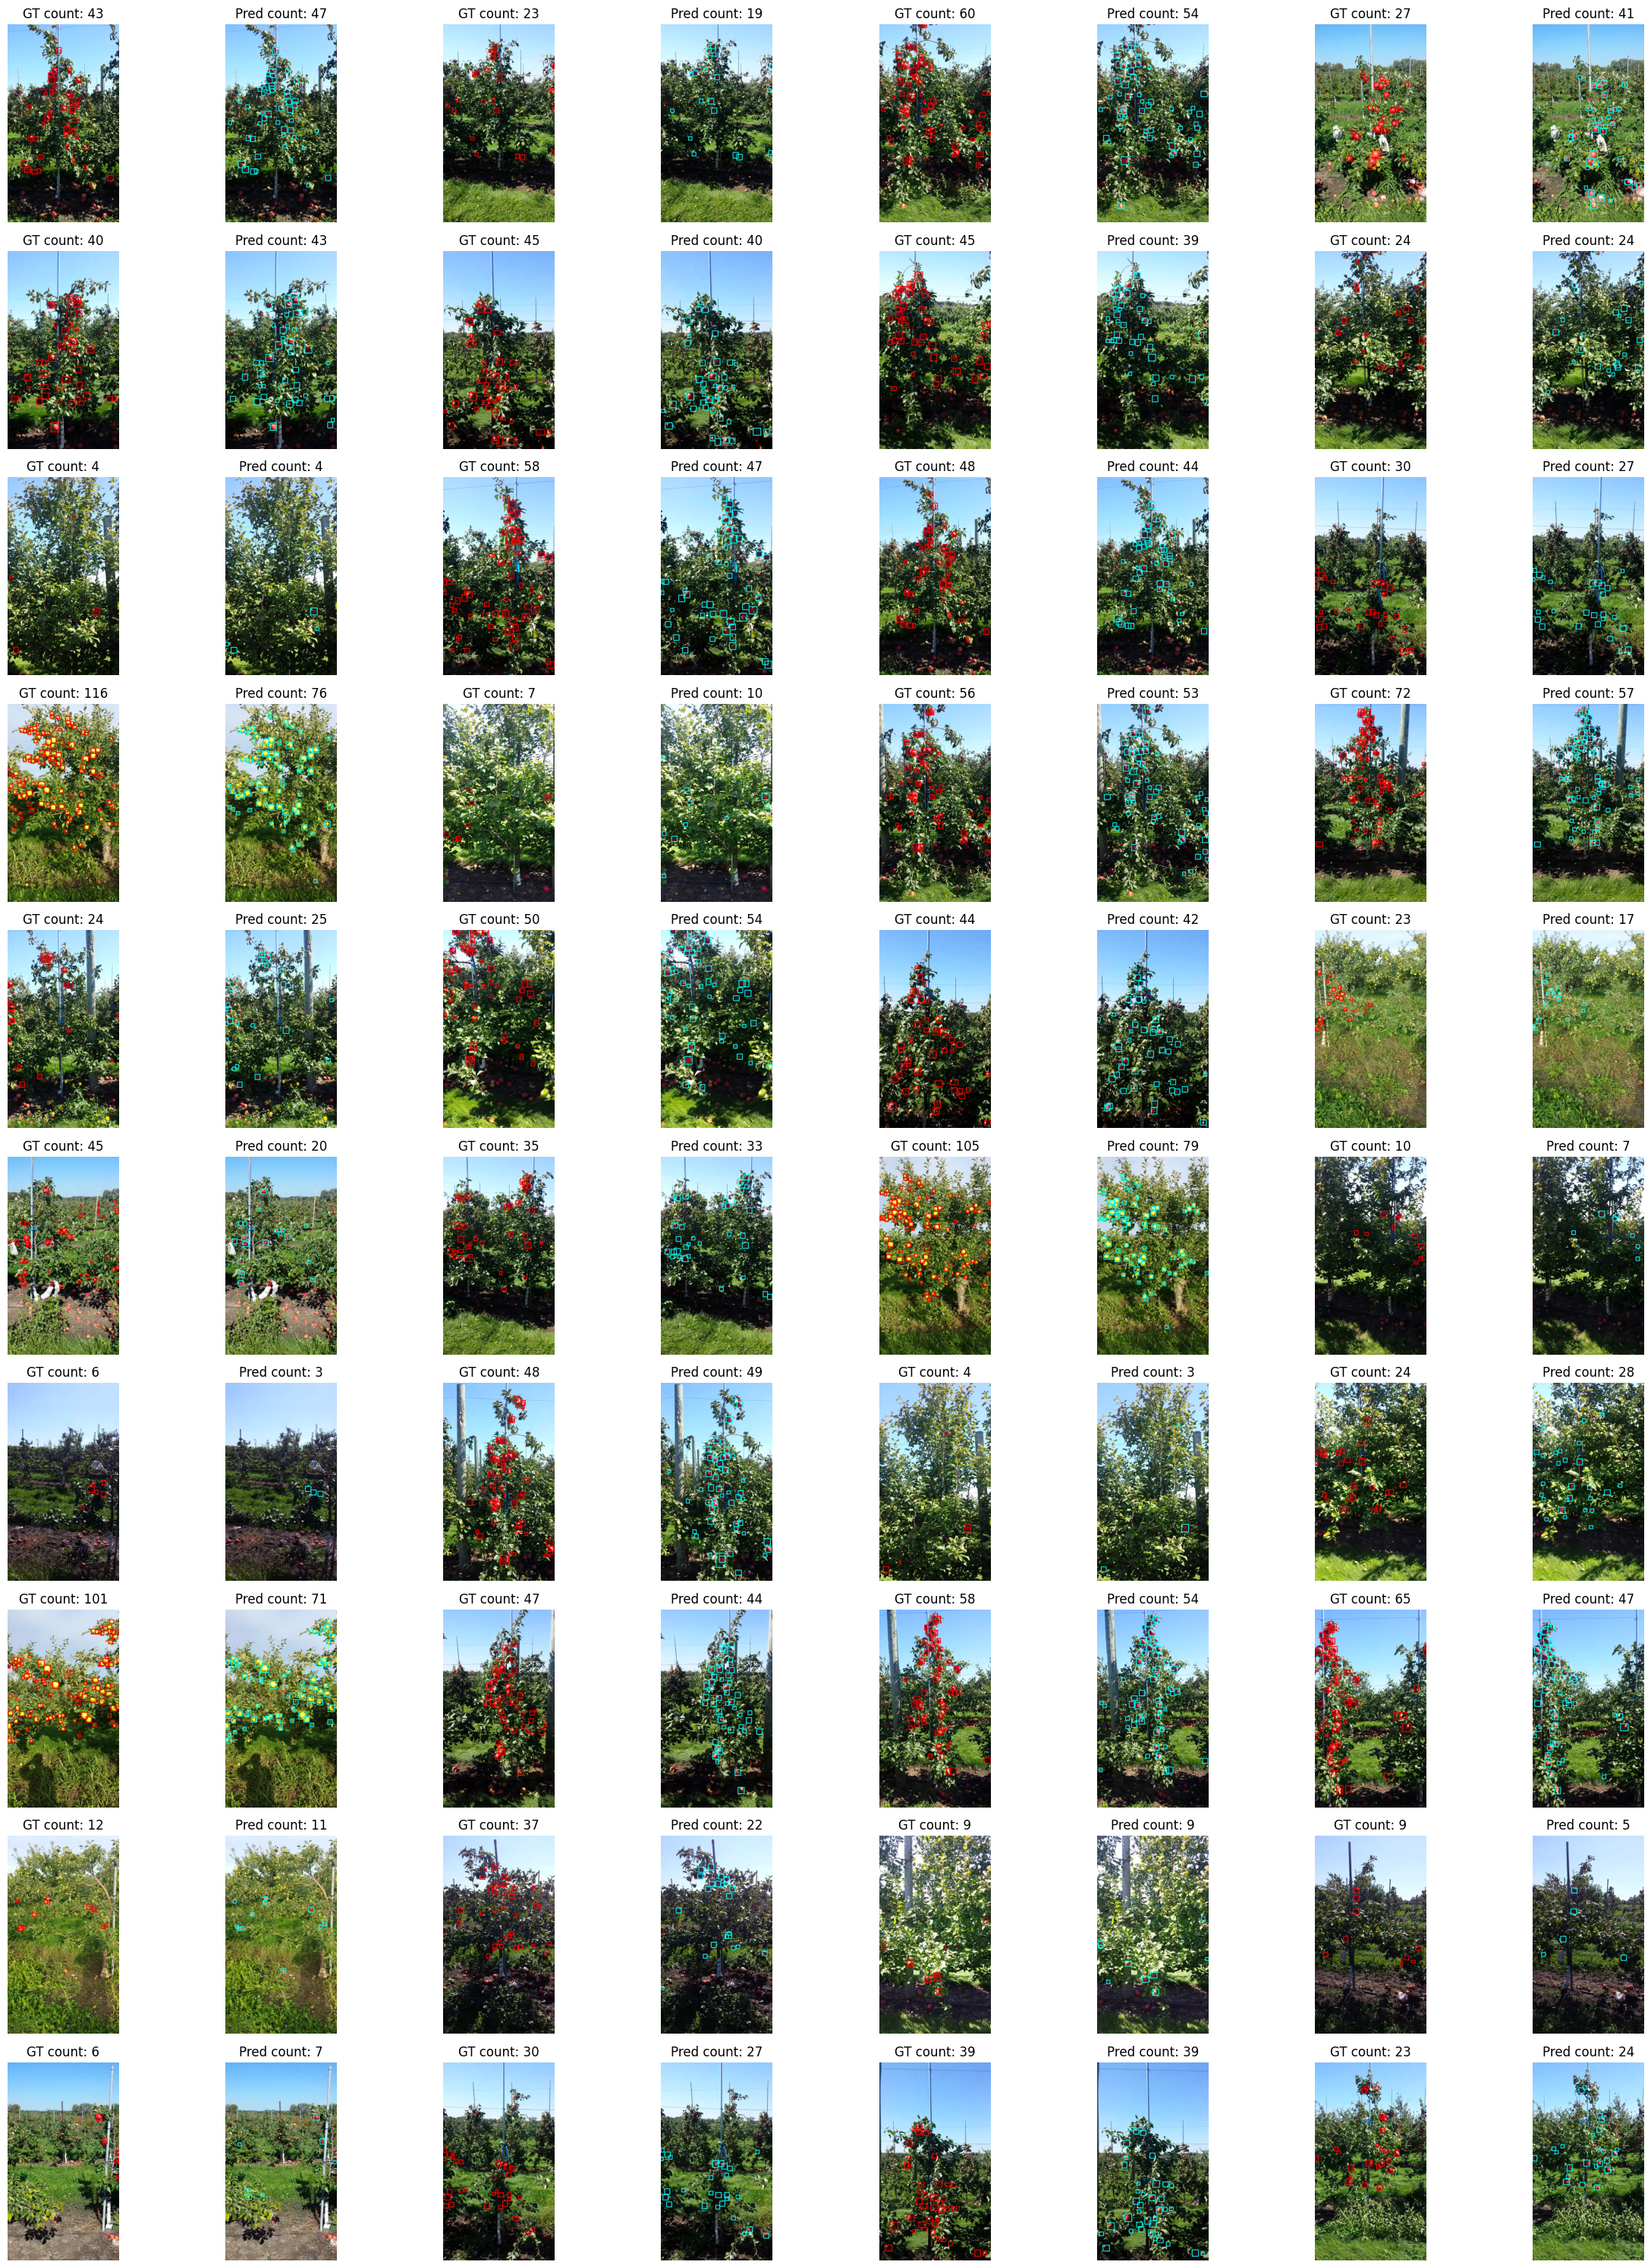

In [82]:
run_gt_vs_result_comparison(40)